## Introduction
Raster datasets are growing exponentially in size and in availability with improvements to data resolution and increase in the frequency of data being captured. This poses a challenge on improving performance of raster operations that can keep up with the growth of raster data sizes.  

In this tutorial, we'll explore methods to leverage both multithreading and multiprocessing of raster datasets that can utilize multiple CPU cores. We'll see the code to implement this using rasterio module and understand the improvements in performance by distributing the raster operation between worker processes. 

We'll revisit the **NDVI** example from Tutorial 1 and calculate this index for a large dataset by utilizing multithreading (concurrency) and multiprocessing (parallelism). I would recommend reading [this medium post](https://medium.com/contentsquare-engineering-blog/multithreading-vs-multiprocessing-in-python-ece023ad55a) that explains concurrency vs parallelism very well. 

### Is there a way around Global Interpreter Lock (GIL)?

A challenge often encountered when analyzing raster datasets and trying to implement distributed processing in Python is the GIL (Global Interpreter Lock). Using rasterio module we can call GDAL __GDALRasterIO( )__ method that enables bypassing Python's Global Interpreter Lock (GIL) for raster data. This makes concurrent read/ writes of cell blocks for large raster datasets possible. Taking advantage of this functionality can help scale your analysis, improve performance and maximize the utilization of processing units in your compute environment.

### Import modules
Let us begin by importing the rasterio, multiprocessing and matplotlib.pylot among other necessary python libraries. We'll also import a built-in method for calculating NDVI from a multiband raster dataset. This methods is stored in the 'Utils' folder in the parent directory of this repository and can be used by importing it.

In [1]:
import os
import time
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import concurrent.futures
from multiprocessing import cpu_count
from Utils.NDVI import create_ndvi_array

### Data
We'll use an image acquired from National Agriculture Imagery Program (NAIP). This is a multiband raster which has the bands (red, NIR) as the first and fourth bands respectively that are required to calculate NDVI index.

##### Data citation Information:
        Originator: USDA-FSA Aerial Photography Field Office
        Publication_Date: 20191022
        Title: NAIP Digital Orthophoto
        Geospatial_Data_Presentation_Form: remote-sensing image

In [2]:
input_file = os.path.join(
        os.getcwd(), 
        r'Data/NAIP/m_3511001_12_060_20190705_20200109.tif'
    )

input_src = rasterio.open(input_file)

Let us explore the data and get a sense of the number of pixels that need to be processed. First we'll check how many bands are present.

In [3]:
input_src.count

4

Next let us inspect the height and width of the raster dataset.

In [4]:
input_src.shape

(24119, 19806)

Since we'll be only using the first and fourth bands for NDVI analysis, that is a total of 24119*19806*2 = 955401828 cells, which is close to **a billion pixels that need to be analysed!**

Define a path to the output NDVI raster.

In [5]:
out_NDVI_raster_c = os.path.join(
        os.getcwd(), 
        r'Data/Outputs/NDVI_concurrent.tif'
    )

out_NDVI_raster_p = os.path.join(
        os.getcwd(), 
        r'Data/Outputs/NDVI_parallel.tif'
    )

out_NDVI_raster_s = os.path.join(
        os.getcwd(), 
        r'Data/Outputs/NDVI_serial.tif'
    )

### Analysis step

This is the analysis step. We'll be using pixel blocks of size 1024 by 1024 to break up the empty output raster into windows. Then, we'll use the same windows to process the input rasters concurrently and write them to the output. We'll time the total time taken to perform analysis and keep track of how long it took on my local machine to run it using 4 cores.

### Concurrent implementation

We'll use ThreadPoolExecutor from concurrent.futures module to achieve concurrency.

In [6]:
start_time = time.perf_counter()

with rasterio.Env():
    with rasterio.open(input_file) as src:
        profile = input_src.profile
        profile.update(blockxsize = 1024, blockysize = 1024, 
                       tiled = True, count=1, dtype=rasterio.float64)
        
        with rasterio.open(out_NDVI_raster_c, "w", **profile) as outras:
            #list of destination windows
            windows = [window for ji, window in outras.block_windows()]
    
            #read input dataset for these windows
            input_window_data = (input_src.read(window=window, masked=True) for window in windows)
            
            # multiply number of processors by 5 to overlap I/O
            with concurrent.futures.ThreadPoolExecutor(
                    max_workers=cpu_count()*5
                ) as executor:
    
                for window, result in zip(
                    windows, executor.map(create_ndvi_array, input_window_data)
                ):
                    outras.write(result, window=window)
        
end_time = time.perf_counter()

total_execution_time_c = end_time - start_time

print("Time to execute concurrently (seconds): {t}".format(t=total_execution_time_c))

Time to execute concurrently (seconds): 30.91653934300001


### Parallel implementation

We'll use the ProcessPoolExecutor from concurrent.futures to achieve parallelism.

In [7]:
start_time = time.perf_counter()

with rasterio.Env():
    with rasterio.open(input_file) as src:
        profile = input_src.profile
        profile.update(blockxsize = 1024, blockysize = 1024, 
                       tiled = True, count=1, dtype=rasterio.float64)
        
        with rasterio.open(out_NDVI_raster_p, "w", **profile) as outras:
            #list of destination windows
            windows = [window for ji, window in outras.block_windows()]
    
            #read input dataset for these windows
            input_window_data = (input_src.read(window=window, masked=True) for window in windows)
    
            with concurrent.futures.ProcessPoolExecutor(
                    max_workers=cpu_count()
                ) as executor:
    
                for window, result in zip(
                    windows, executor.map(create_ndvi_array, input_window_data)
                ):
                    outras.write(result, window=window)
        
end_time = time.perf_counter()

total_execution_time_p = end_time - start_time

print("Time to execute in parallel (seconds): {t}".format(t=total_execution_time_p))

Time to execute in parallel (seconds): 61.25914997199999


### Serial implementation

In [8]:
profile = input_src.profile
profile.update(count=1, dtype=rasterio.float64)


start_time = time.perf_counter()
with rasterio.open(out_NDVI_raster_s, "w", **profile) as outras:
    NDVI_array = create_ndvi_array(input_src.read(masked=True))
    outras.write(NDVI_array)
    
end_time = time.perf_counter()

total_execution_time_s = end_time - start_time
print("Time to execute serially (seconds): {t}".format(t=total_execution_time_s))
    

Time to execute serially (seconds): 173.75704774899998


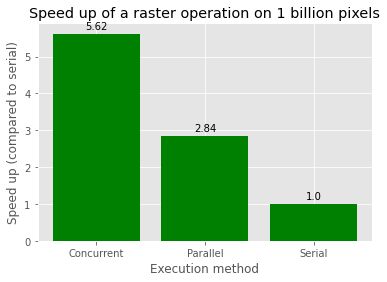

In [25]:
plt.style.use('ggplot')
x = ['Concurrent', 'Parallel', 'Serial']
#baseline (slowest) which is serial is 1x
y = [total_execution_time_s/time for time in [total_execution_time_c, total_execution_time_p, total_execution_time_s]]
x_pos = [i for i, _ in enumerate(x)]

br = plt.bar(x_pos, y, color='green')
plt.xlabel("Execution method")
plt.ylabel("Speed up (compared to serial)")
plt.title("Speed up of a raster operation on 1 billion pixels")

def autolabel(rects):
    for rect in rects:
        height = round(rect.get_height(), 2)
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(br)
plt.xticks(x_pos, x)
plt.show()